<a href="https://colab.research.google.com/github/Raheelrazzaq063/finalyearproject/blob/main/new_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
#Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE

Load and Clean Datas

In [ ]:
# Load dataset
df = pd.read_csv("breast-cancer-data.csv")

# Rename typo column
df.rename(columns={'tumer-size': 'tumor-size'}, inplace=True)

# Strip extra apostrophes
df = df.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)

# Convert and fill missing
df['deg-malig'] = pd.to_numeric(df['deg-malig'])
df['node-caps'].fillna(df['node-caps'].mode()[0], inplace=True)
df['breast-quad'].fillna(df['breast-quad'].mode()[0], inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)


/tmp/ipython-input-2-1337506813.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)
/tmp/ipython-input-2-1337506813.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['node-caps'].fillna(df['node-caps'].mode()[0], inplace=True)
/tmp/ipython-input-2-1337506813.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will chan

Prepare Target and Features

In [ ]:
# Encode target variable
df['class'] = df['class'].map({'no-recurrence-events': 0, 'recurrence-events': 1})

# One-hot encode categorical features
cat_cols = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'breast', 'breast-quad', 'irradiate']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Define features and target
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']


EDA

/tmp/ipython-input-4-1012728159.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,


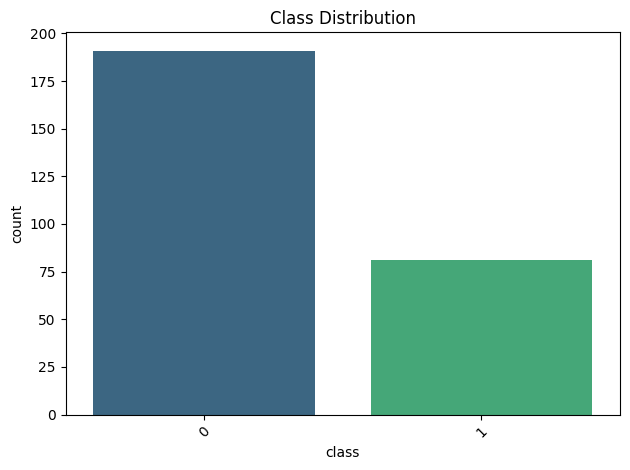

class
0    191
1     81
Name: count, dtype: int64


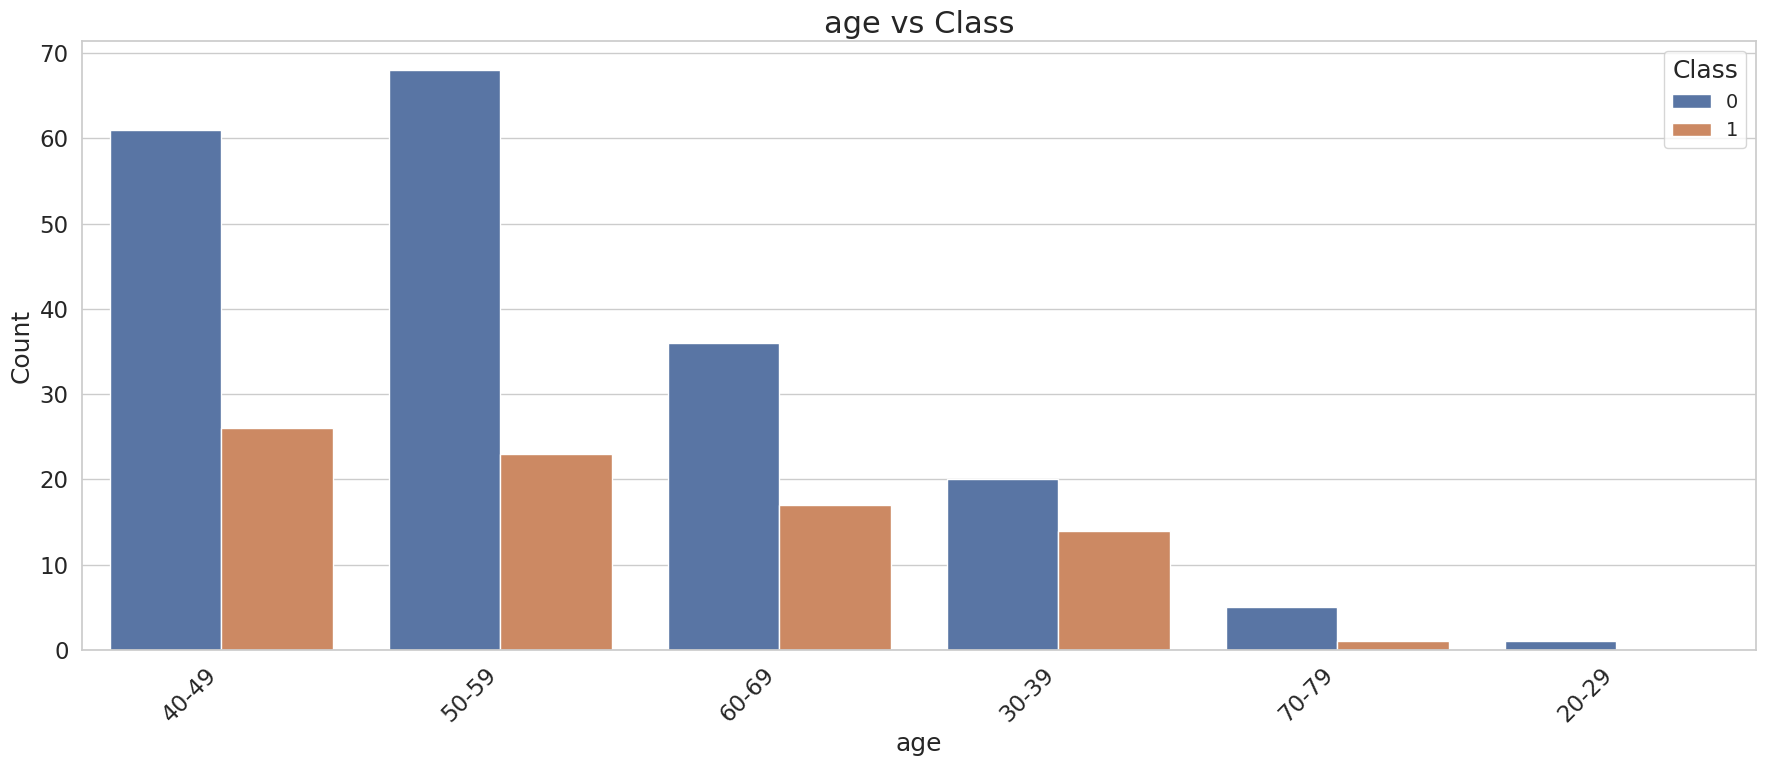

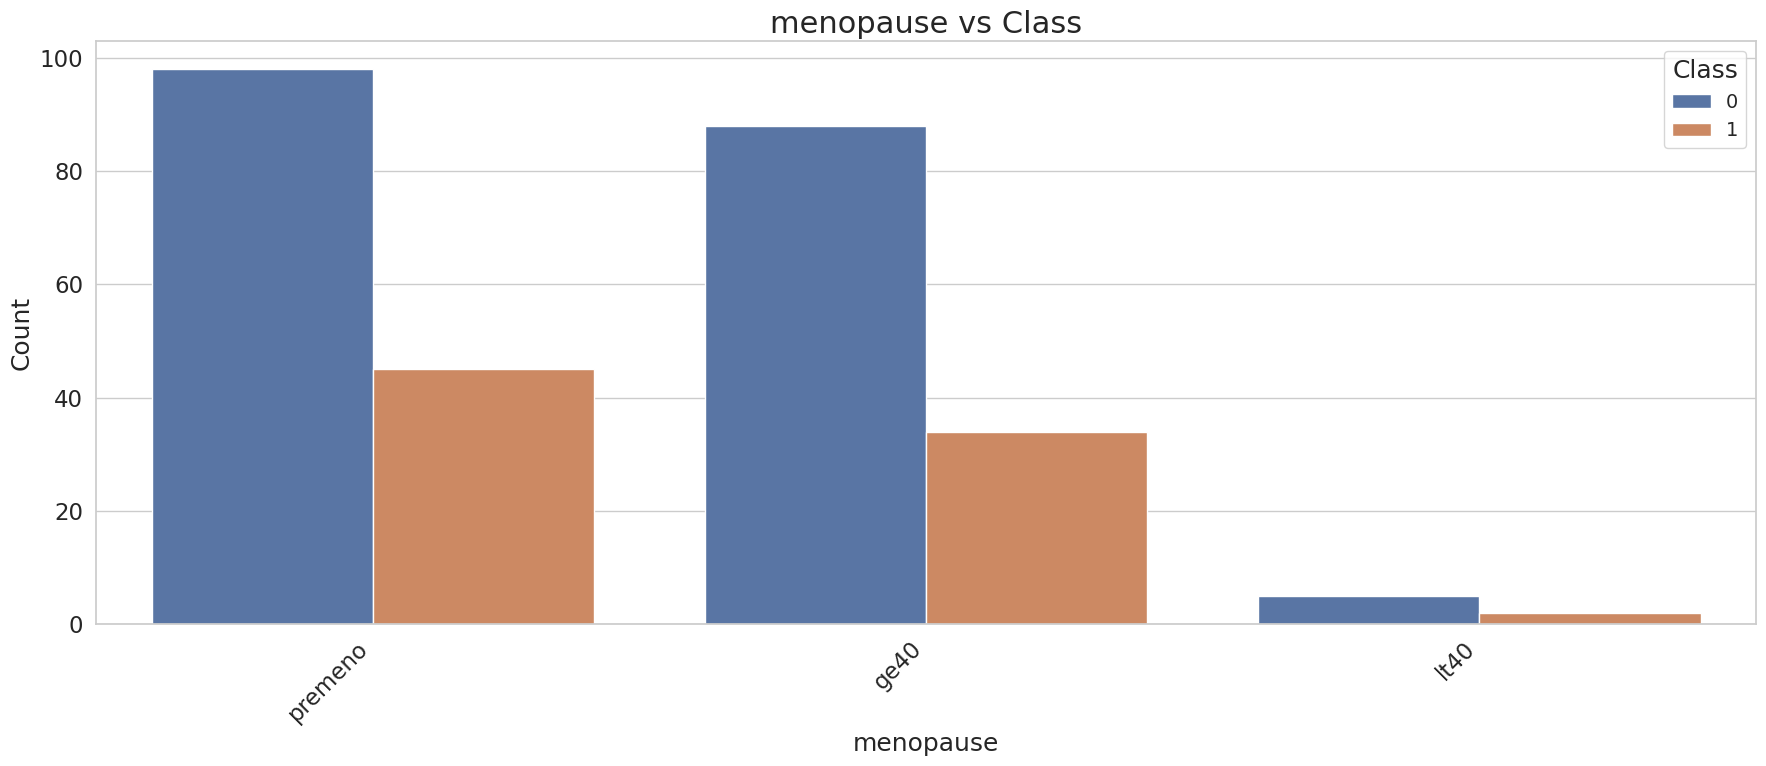

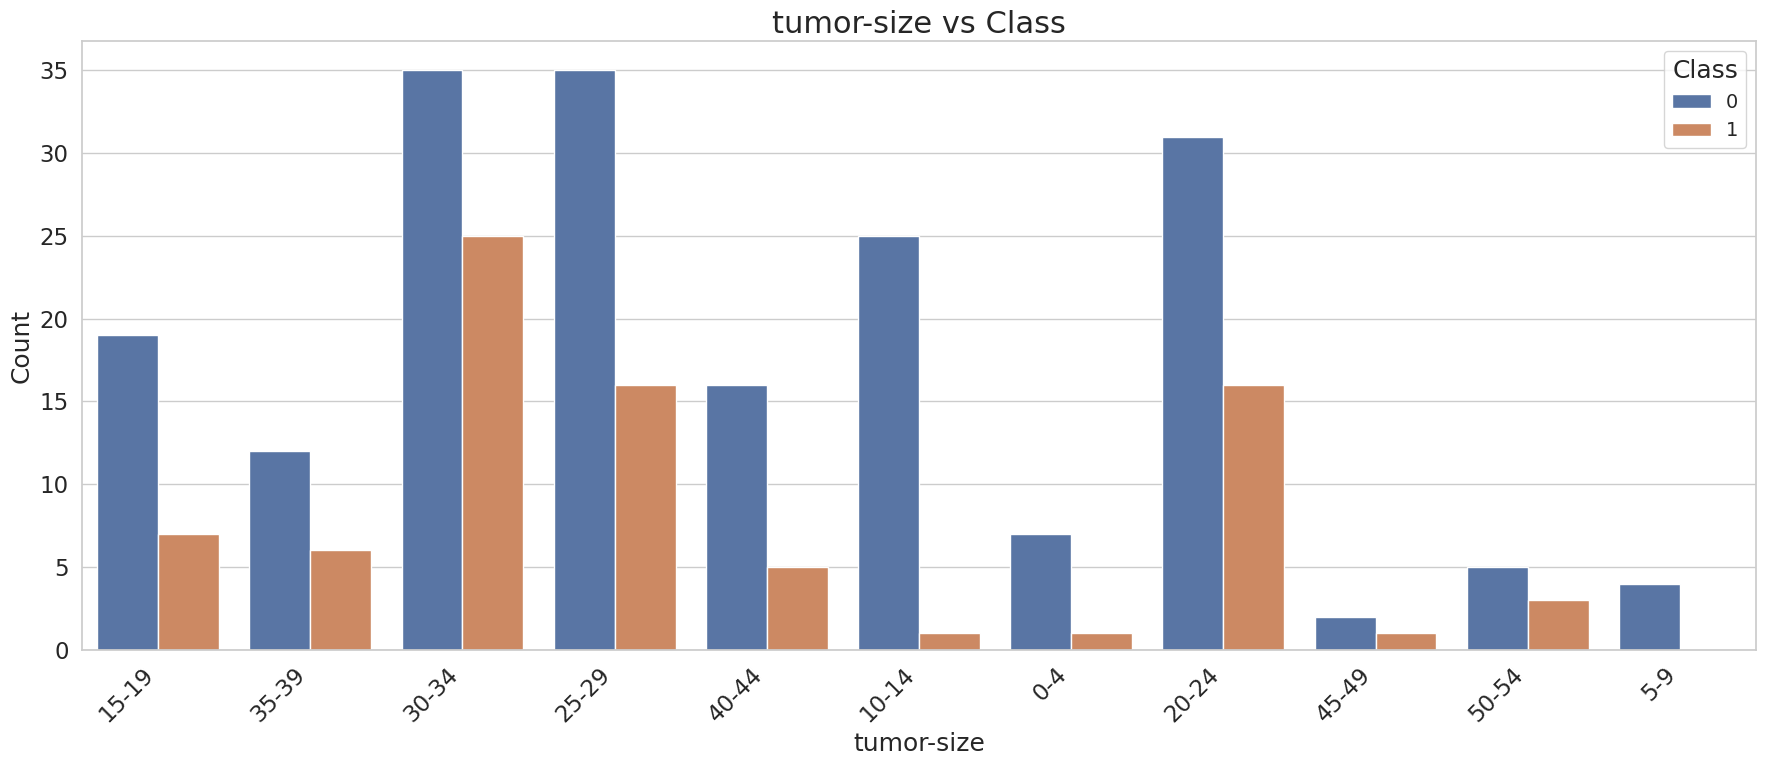

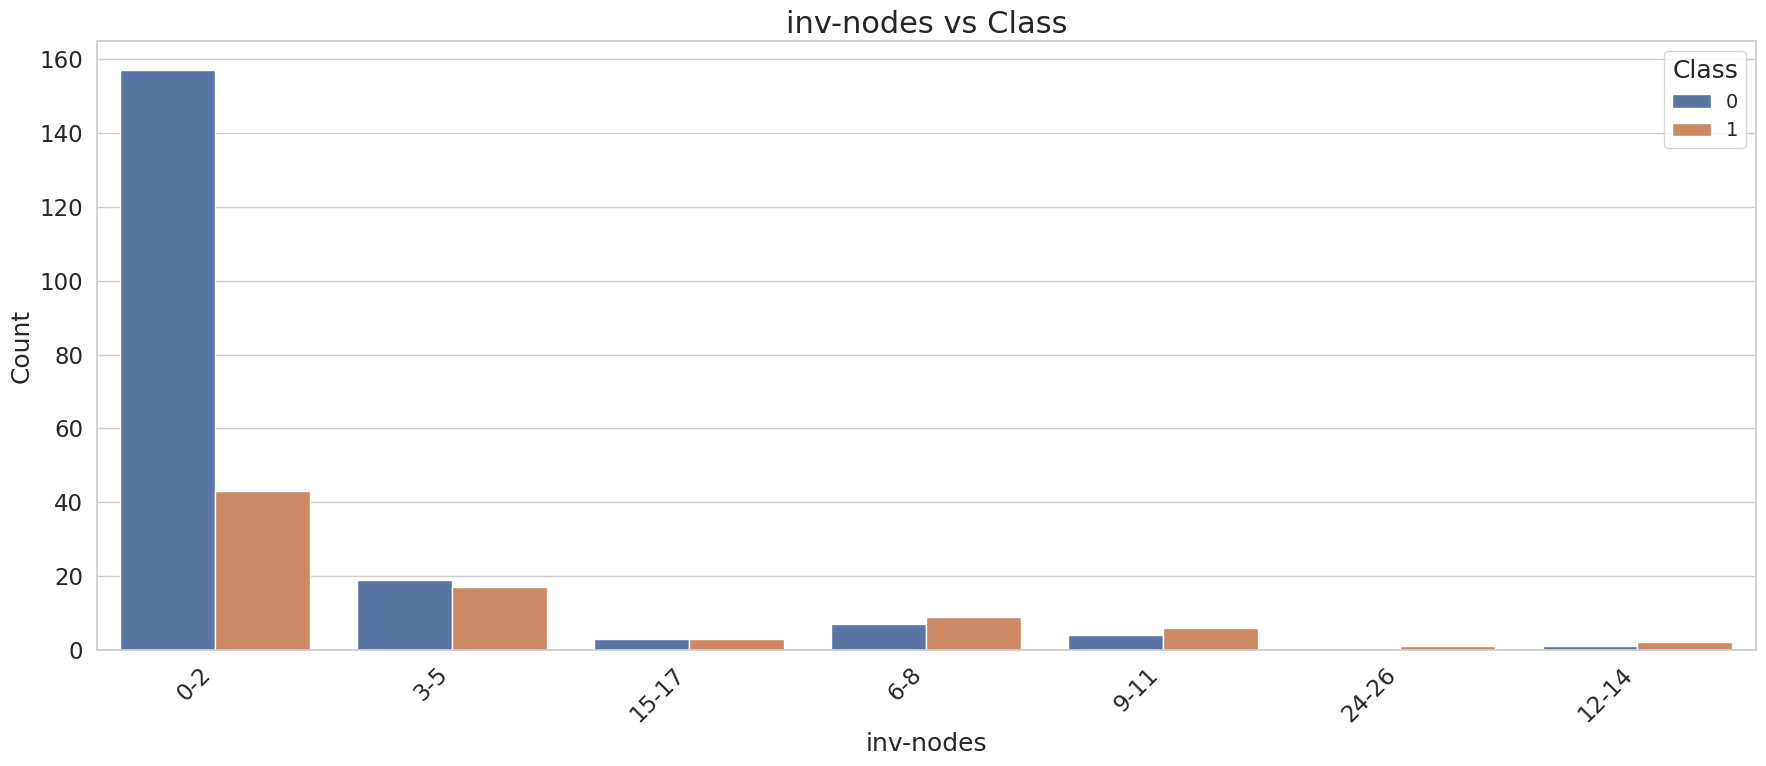

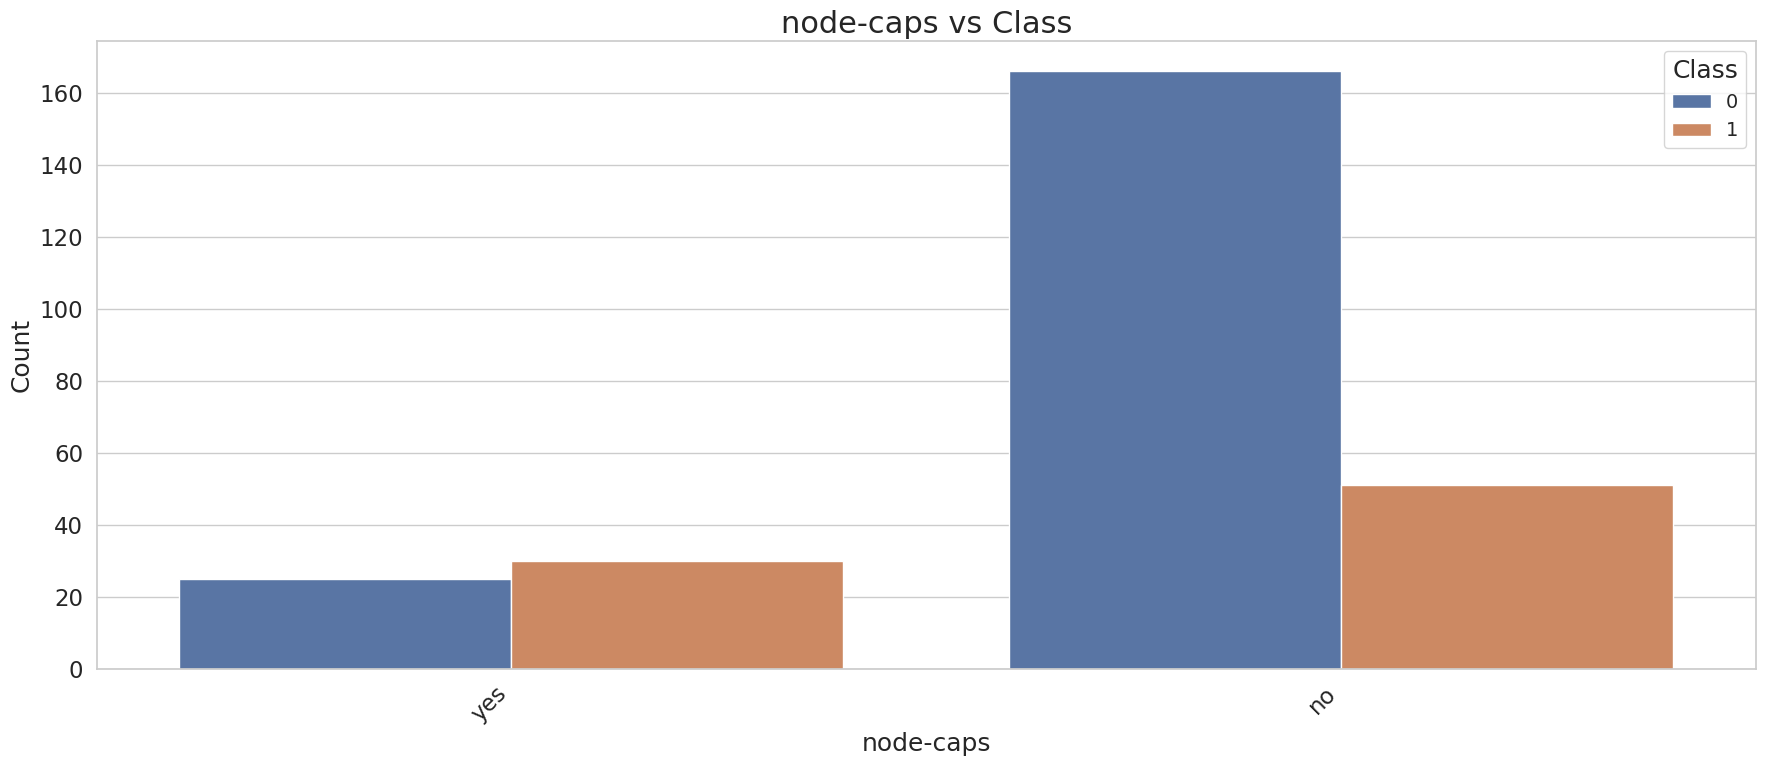

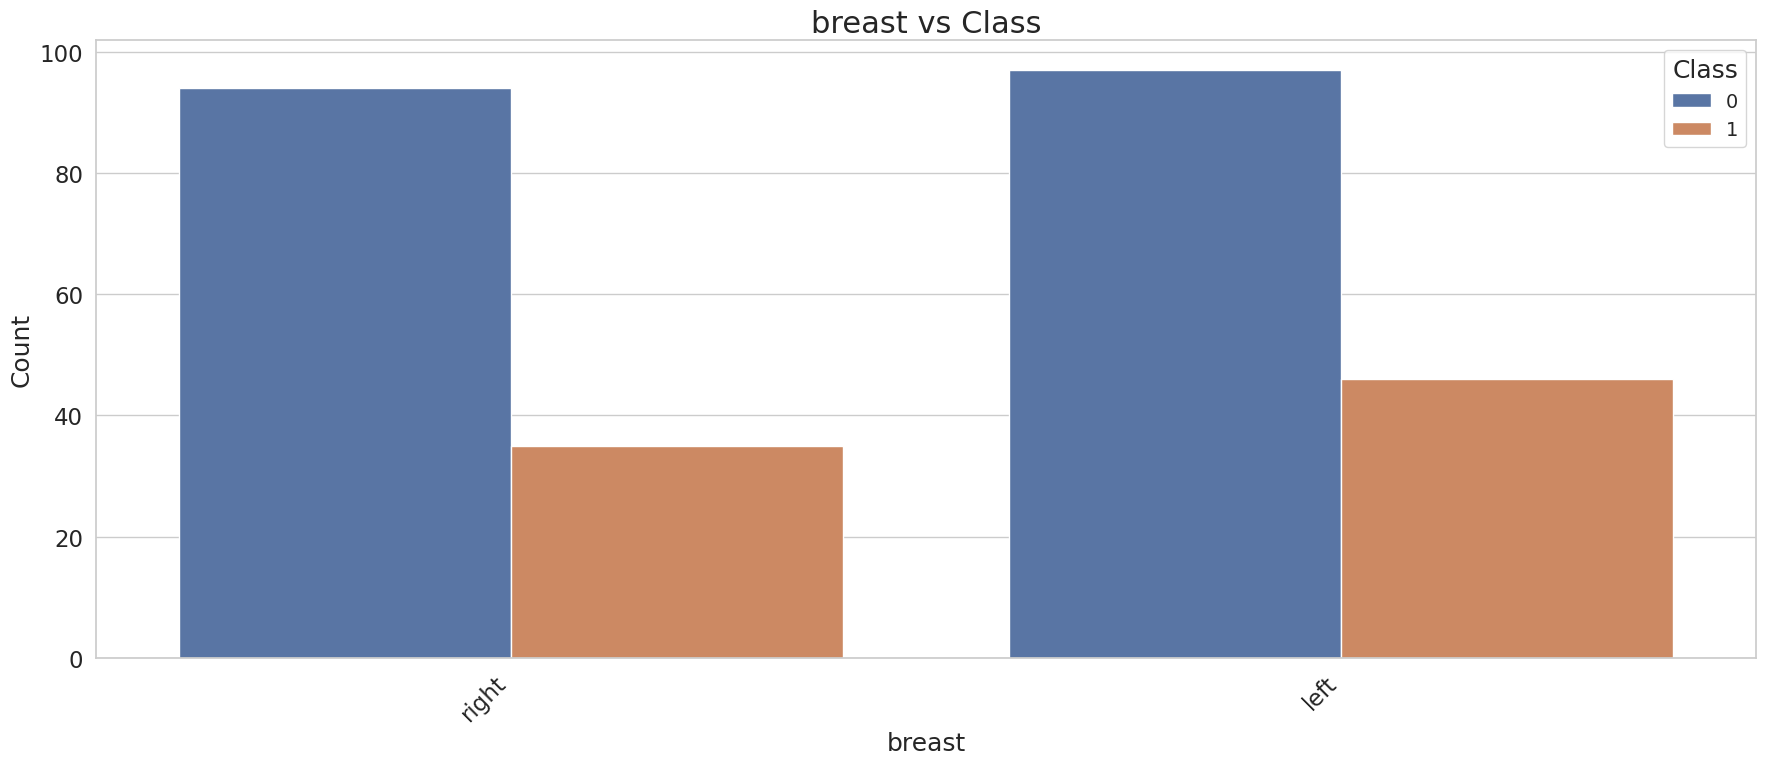

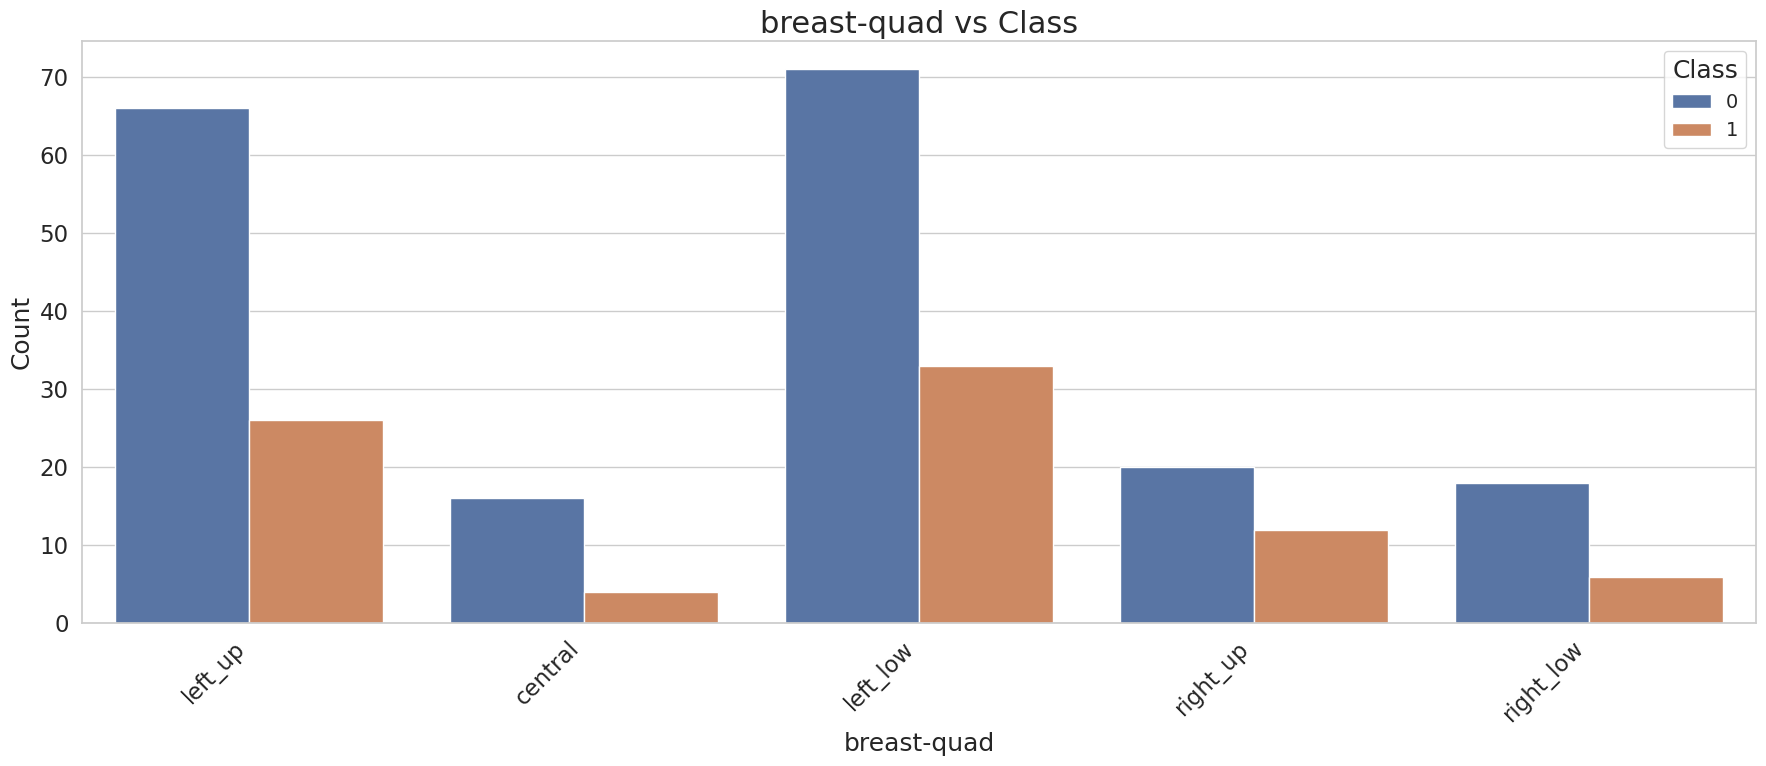

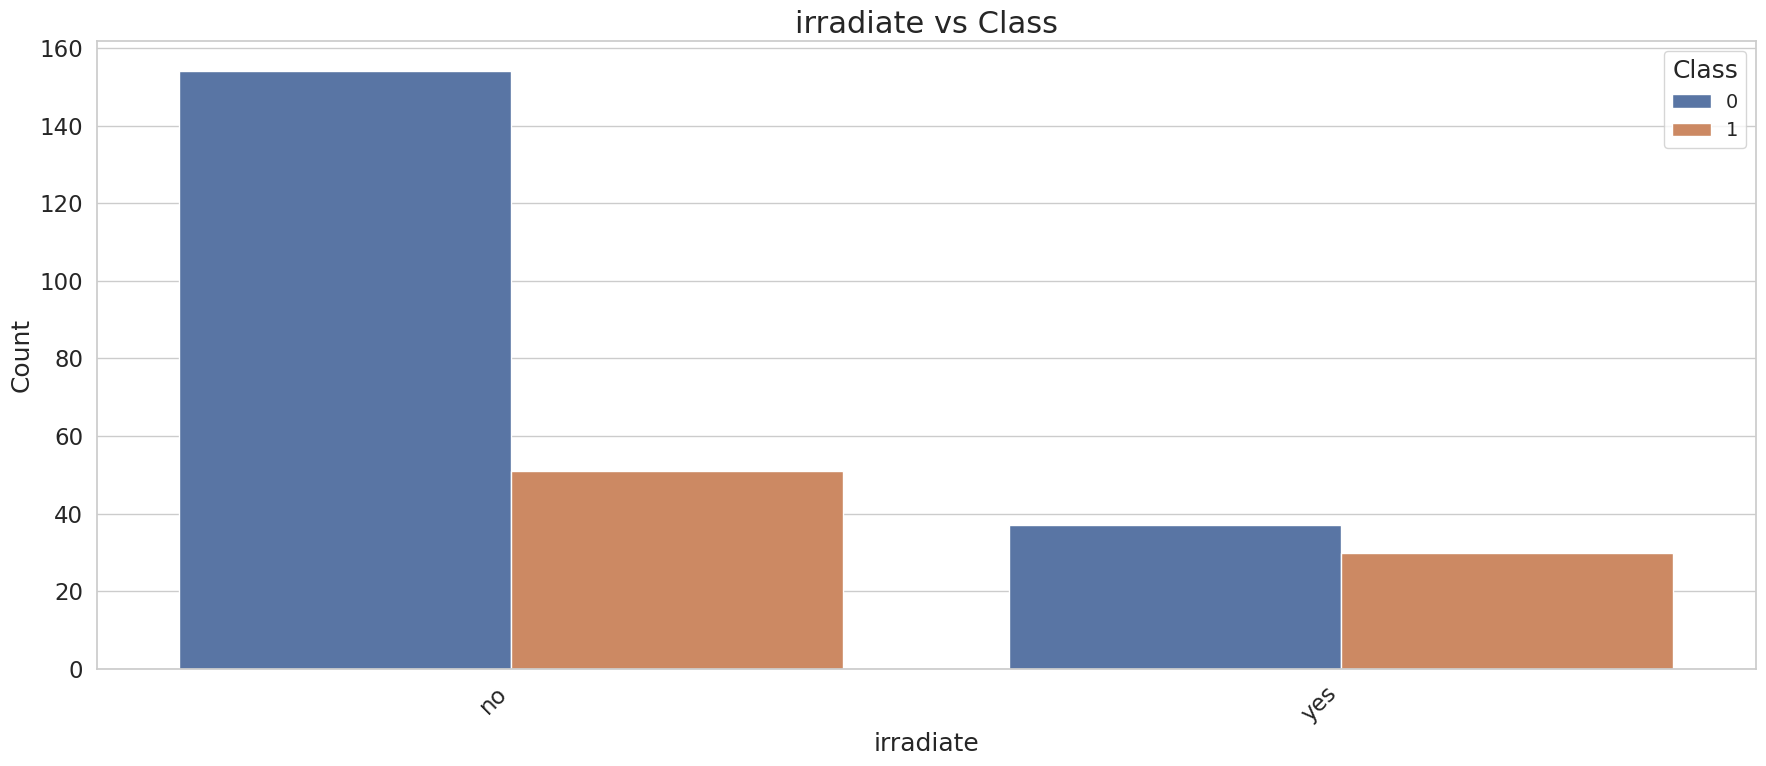

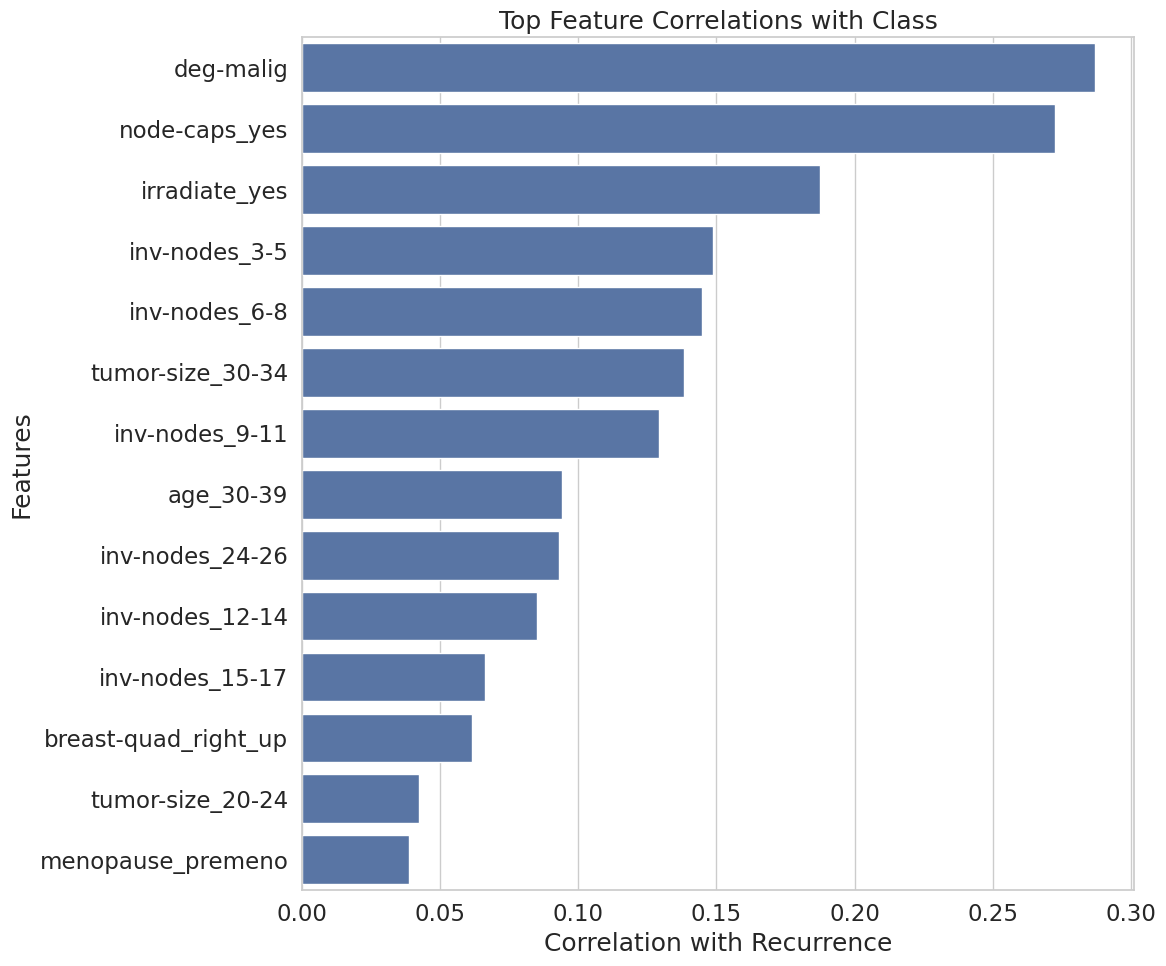

In [ ]:
# -------------------------------------
# Visualizations
# -------------------------------------

# Class distribution
sns.countplot(data=df,
              x='class',
              palette='viridis')

plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(df['class'].value_counts())

# Categorical feature distribution by class
sns.set(style="whitegrid", font_scale=1.5)
categorical_cols = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'breast', 'breast-quad', 'irradiate']
for col in categorical_cols:
    plt.figure(figsize=(18, 8))
    sns.countplot(data=df, x=col, hue='class')
    plt.title(f'{col} vs Class', fontsize=22)
    plt.xlabel(col, fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Class', fontsize=14)
    plt.tight_layout()
    plt.show()

# Correlation with class
plt.figure(figsize=(12, 10))
corr_matrix = df_encoded.corr()
corr_target = corr_matrix['class'].sort_values(ascending=False)
sns.barplot(x=corr_target.values[1:15], y=corr_target.index[1:15])
plt.title('Top Feature Correlations with Class')
plt.xlabel('Correlation with Recurrence')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

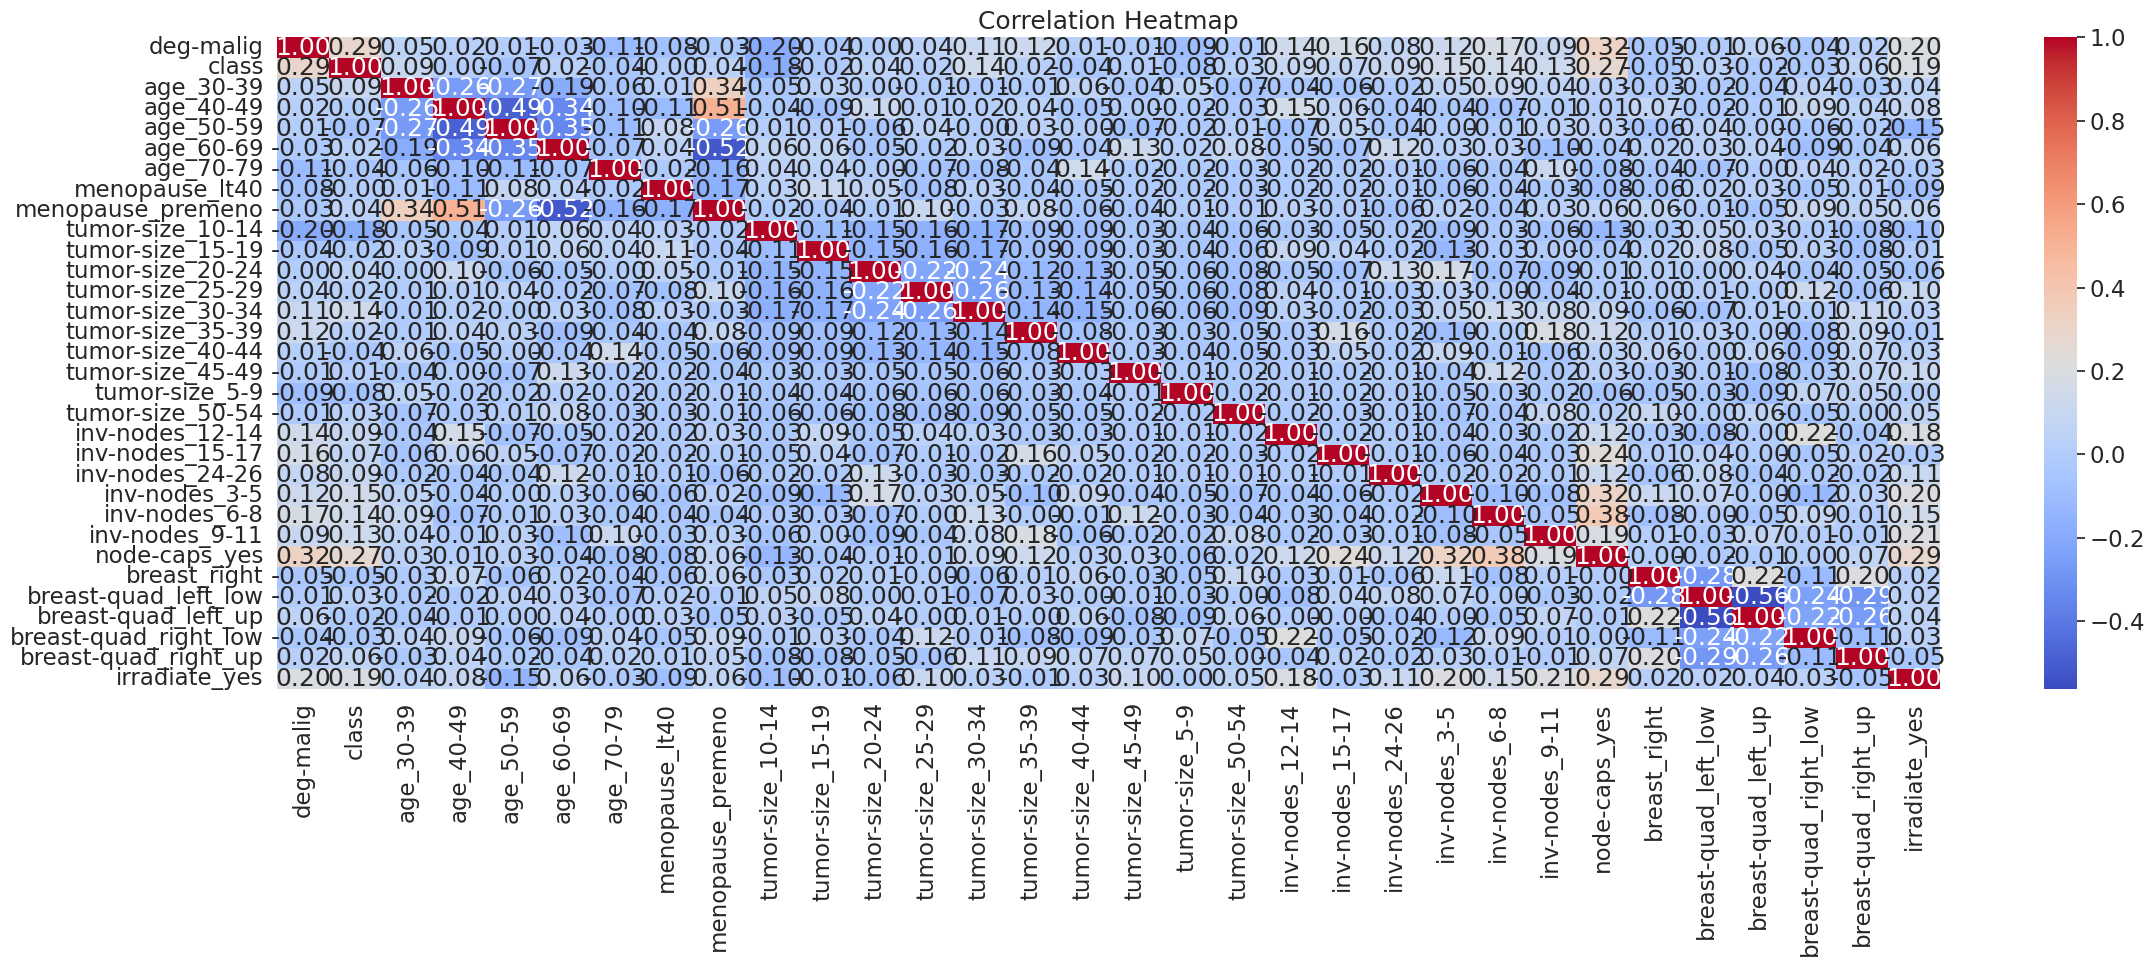

In [ ]:
#Heatmap of Feature Correlations
plt.figure(figsize=(24, 10))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


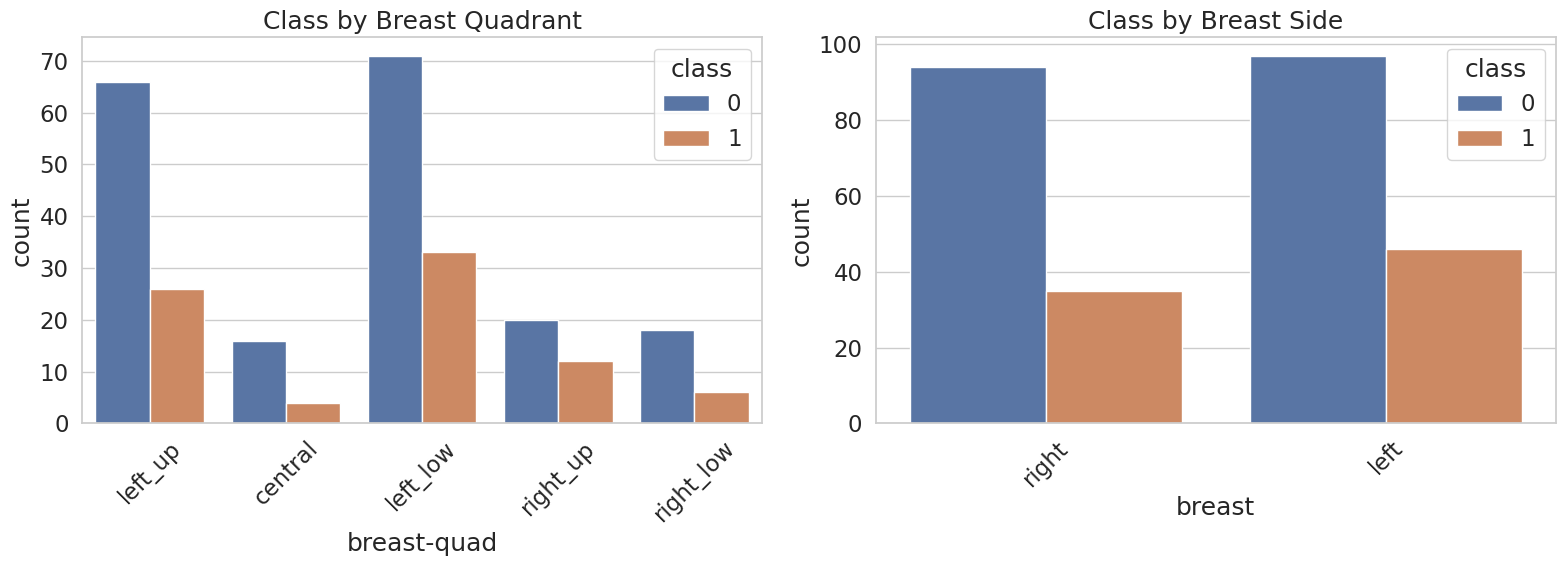

In [ ]:
#Class Distribution per Quadrant and Side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=df, x='breast-quad', hue='class', ax=axes[0])
axes[0].set_title("Class by Breast Quadrant")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(data=df, x='breast', hue='class', ax=axes[1])
axes[1].set_title("Class by Breast Side")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


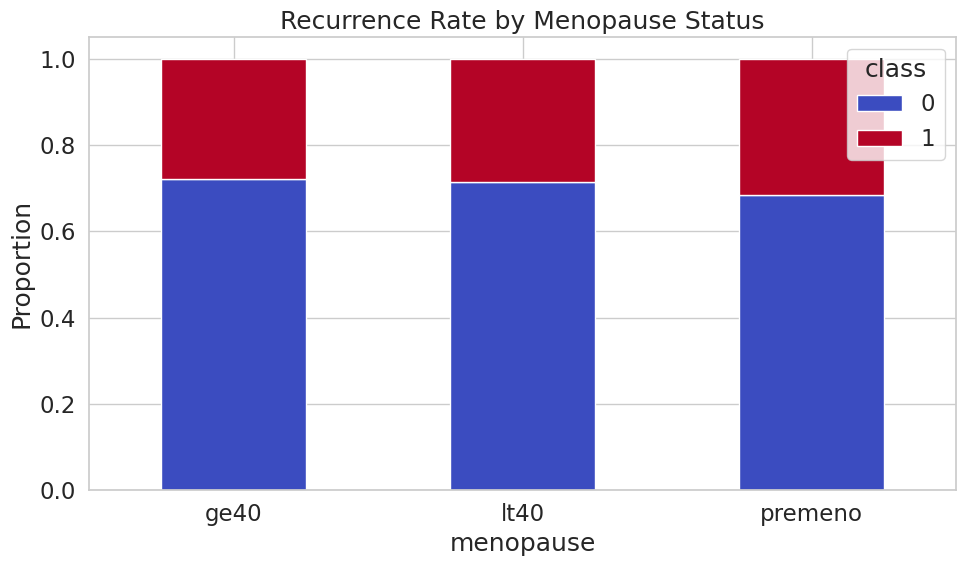

In [ ]:
#Barplot of Recurrence Rate by Menopause Status
recurrence_rate = df.groupby('menopause')['class'].value_counts(normalize=True).unstack().fillna(0)
recurrence_rate.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Recurrence Rate by Menopause Status')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Handle Class Imbalance with SMOTE

In [ ]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


Train-Test Split

In [ ]:
# Stratified split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)


Define Models and Hyperparameter Grids

In [ ]:
models_params = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, random_state=42),
        {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['liblinear', 'lbfgs']
        }
    ),
    'SVM': (
        SVC(probability=True, random_state=42),
        {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10]
        }
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, None]
        }
    ),
    'XGBoost': (
        xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    )
}


Evaluation Function

In [ ]:
def evaluate_and_plot(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    return acc, prec, rec, f1

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}
metrics_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}




GridSearchCV Tuning and Evaluation




🔍 Tuning and Evaluating: Logistic Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression Performance:
Accuracy:  0.6883
Precision: 0.6667
Recall:    0.7368
F1 Score:  0.7000


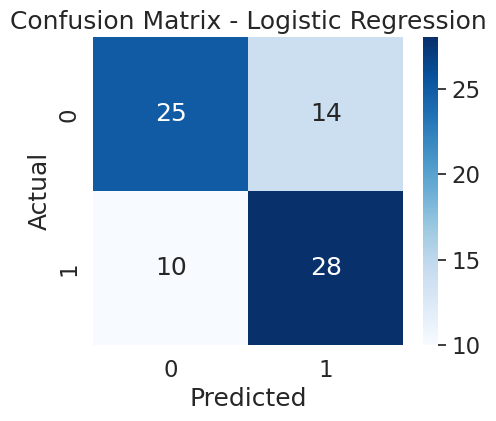


🔍 Tuning and Evaluating: SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

SVM Performance:
Accuracy:  0.7403
Precision: 0.7250
Recall:    0.7632
F1 Score:  0.7436


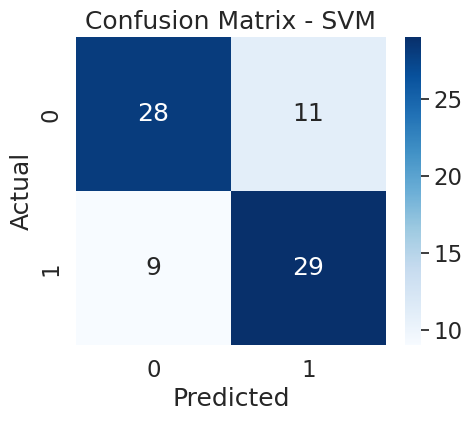


🔍 Tuning and Evaluating: Decision Tree
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best Parameters: {'max_depth': None, 'min_samples_split': 2}

Decision Tree Performance:
Accuracy:  0.6494
Precision: 0.6341
Recall:    0.6842
F1 Score:  0.6582


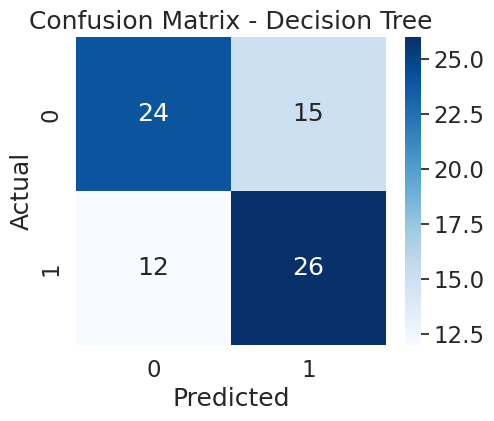


🔍 Tuning and Evaluating: Random Forest
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Parameters: {'max_depth': 10, 'n_estimators': 100}

Random Forest Performance:
Accuracy:  0.7273
Precision: 0.6977
Recall:    0.7895
F1 Score:  0.7407


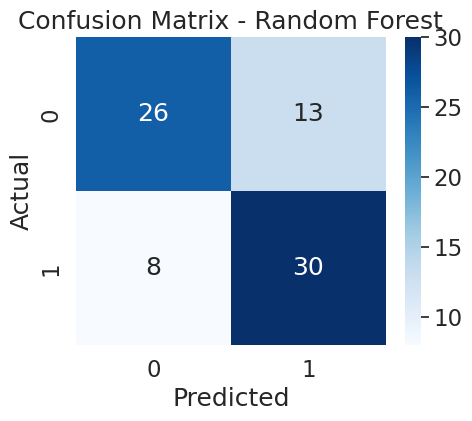


🔍 Tuning and Evaluating: XGBoost
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:40:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

XGBoost Performance:
Accuracy:  0.7013
Precision: 0.6667
Recall:    0.7895
F1 Score:  0.7229


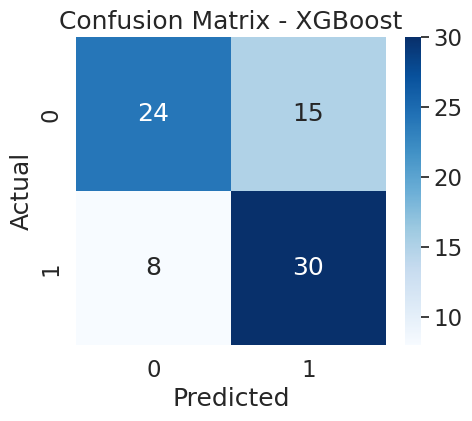

In [ ]:
# Grid search and evaluation
for name, (model, params) in models_params.items():
    print(f"\n🔍 Tuning and Evaluating: {name}")
    grid = GridSearchCV(model, params, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    print(f"✅ Best Parameters: {grid.best_params_}")

    acc, prec, rec, f1 = evaluate_and_plot(name, best_model, X_test, y_test)
    best_models[name] = best_model

    metrics_summary['Model'].append(name)
    metrics_summary['Accuracy'].append(acc)
    metrics_summary['Precision'].append(prec)
    metrics_summary['Recall'].append(rec)
    metrics_summary['F1 Score'].append(f1)

Plot Metric Comparison

/tmp/ipython-input-13-4289409071.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='viridis')


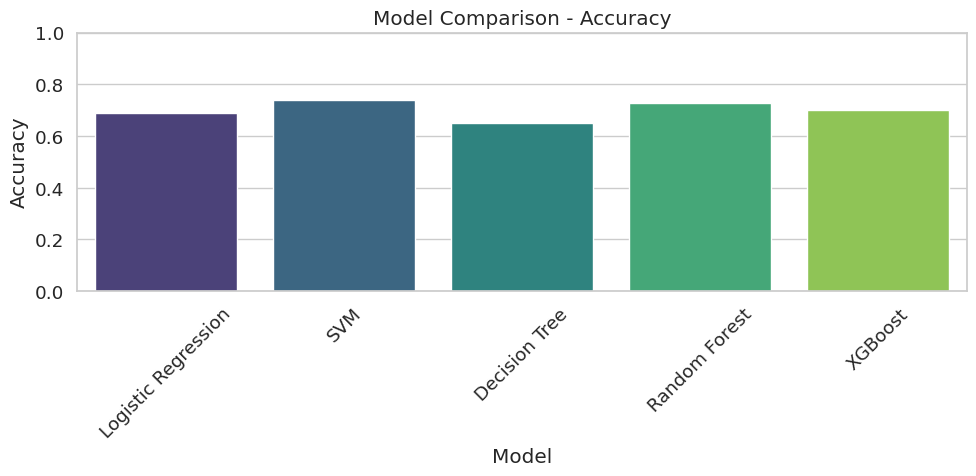

/tmp/ipython-input-13-4289409071.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='viridis')


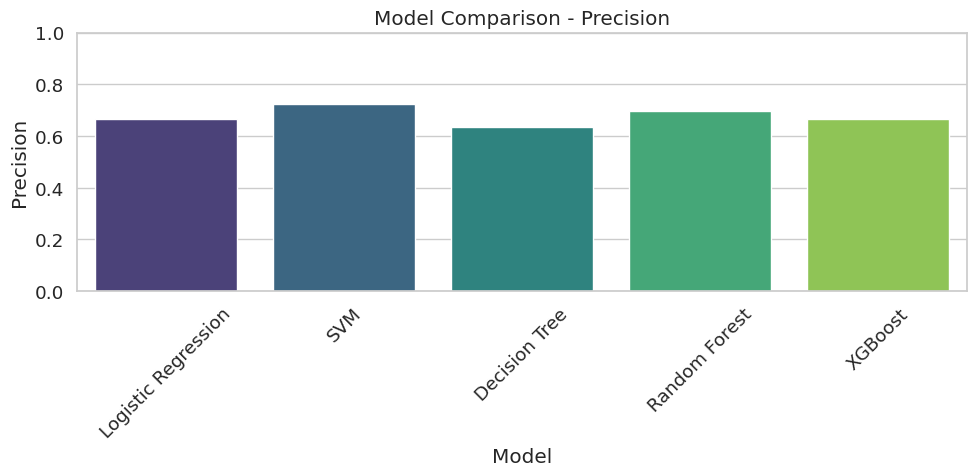

/tmp/ipython-input-13-4289409071.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='viridis')


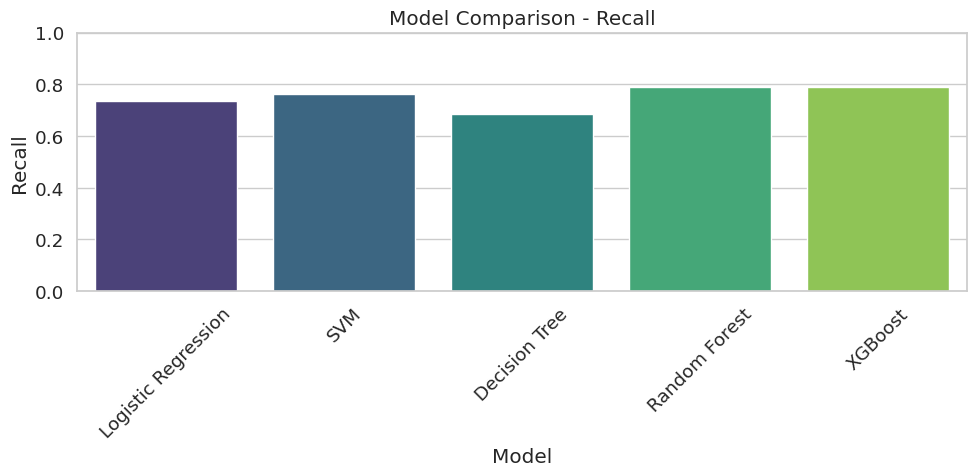

/tmp/ipython-input-13-4289409071.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='viridis')


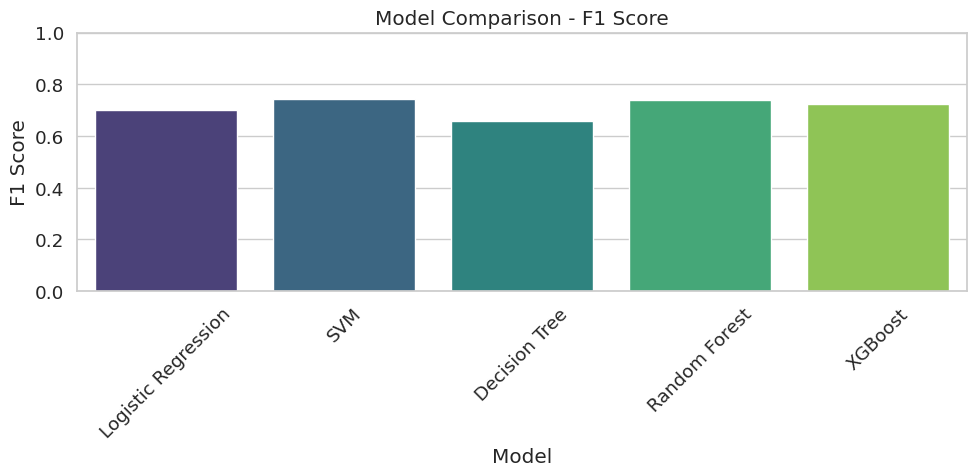

In [ ]:
# Bar Plots for Each Metric
metrics_df = pd.DataFrame(metrics_summary)

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# List of metric columns
metric_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plot each metric separately
for metric in metric_columns:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=metrics_df, x='Model', y=metric, palette='viridis')
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
